In [ ]:
#Importing Libraries
import pandas as pd
import re
from nltk import trigrams, word_tokenize
from collections import defaultdict, Counter
import nltk

In [ ]:
# Download NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##PART I

In [ ]:
# Dataset Loading
url = "IMDB.csv"
df = pd.read_csv(url)

In [ ]:
# Check the dataset
print(df.head())

   ID                                             review
0   1  One of the other reviewers has mentioned that ...
1   2  A wonderful little production. <br /><br />The...
2   3  I thought this was a wonderful way to spend ti...
3   4  Basically there's a family where a little boy ...
4   5  Petter Mattei's "Love in the Time of Money" is...


In [ ]:
#Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['cleaned_review'] = df['review'].apply(preprocess_text)

In [ ]:
# Tokenize text into trigrams
trigram_model = defaultdict(Counter)

for review in df['cleaned_review']:
    tokens = word_tokenize(review)
    trigrams_in_review = list(trigrams(tokens))
    for w1, w2, w3 in trigrams_in_review:
        trigram_model[(w1, w2)][w3] += 1

In [ ]:
# Calculate probabilities
def calculate_trigram_probability(sentence, model):
    tokens = word_tokenize(sentence.lower())
    trigrams_in_sentence = list(trigrams(tokens))
    probability = 1.0
    for w1, w2, w3 in trigrams_in_sentence:
        if model[(w1, w2)][w3] == 0:
            probability *= 1e-6  # Smoothing for unseen trigrams
        else:
            probability *= model[(w1, w2)][w3] / sum(model[(w1, w2)].values())
    return probability

In [ ]:
# Test sentences
test_sentence_1 = "The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO."
test_sentence_2 = "This was the most I'd laughed at one of Woody's comedies in years."

In [ ]:
# Preprocess test sentences
cleaned_test_sentence_1 = preprocess_text(test_sentence_1)
cleaned_test_sentence_2 = preprocess_text(test_sentence_2)

In [ ]:
# Calculate probabilities
prob_sentence_1 = calculate_trigram_probability(cleaned_test_sentence_1, trigram_model)
prob_sentence_2 = calculate_trigram_probability(cleaned_test_sentence_2, trigram_model)

In [ ]:
# Print results
print(f"Probability of Test Sentence 1: {prob_sentence_1}")
print(f"Probability of Test Sentence 2: {prob_sentence_2}")

Probability of Test Sentence 1: 1.762113742553096e-11
Probability of Test Sentence 2: 1.7986678141139513e-08


In [ ]:
# Determining which sentence is more relevant
if prob_sentence_1 > prob_sentence_2:
    print("Test Sentence 1 is more relevant.")
else:
    print("Test Sentence 2 is more relevant.")

Test Sentence 2 is more relevant.


## PART II

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# a. Tokenization
def tokenize(text):
    return word_tokenize(text)

In [ ]:
# b. Lowercasing
def to_lowercase(tokens):
    return [token.lower() for token in tokens]

In [ ]:
# c. Stop Words Removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

In [ ]:
# d. Stemming
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

In [ ]:
# e. Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
# Full preprocessing pipeline
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenize(text)
    tokens = to_lowercase(tokens)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)
    tokens = lemmatize_tokens(tokens)
    return tokens

In [ ]:
df['processed_review'] = df['review'].apply(preprocess_text)

In [ ]:
#Printing pre-processed data
print(df[['review', 'processed_review']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                    processed_review  
0  [one, review, mention, watch, oz, episod, youl...  
1  [wonder, littl, product, film, techniqu, unass...  
2  [thought, wonder, way, spend, time, hot, summe...  
3  [basic, there, famili, littl, boy, jake, think...  
4  [petter, mattei, love, time, money, visual, st...  


In [ ]:
#Feature Extraction using Skip Gram
from gensim.models import Word2Vec

In [ ]:
# Preparing the data for Word2Vec
sentences = df['processed_review'].tolist()

In [ ]:
# Create Skip Gram model
skip_gram_model = Word2Vec(sentences, vector_size=100, window=5, sg=1, min_count=1, workers=4)

In [ ]:
# Inspecting the embeddings for a sample word
word = 'violence'
if word in skip_gram_model.wv.key_to_index:
    print(f"Embedding for '{word}': {skip_gram_model.wv[word]}")
else:
    print(f"Word '{word}' not in vocabulary")

Word 'violence' not in vocabulary


In [ ]:
# Saving the model for further use if required
skip_gram_model.save("skip_gram_model.model")

##PART III

In [ ]:
# Similarity Analysis
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Function to check similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [ ]:
# Finding top 2 similar words to a given word
def top_similar_words(word, model, top_n=2):
    if word not in model.wv.key_to_index:
        return None
    word_vec = model.wv[word]
    similarities = {}
    for other_word in model.wv.key_to_index:
        if other_word != word:
            other_word_vec = model.wv[other_word]
            similarity = cosine_similarity(word_vec, other_word_vec)
            similarities[other_word] = similarity
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_similarities[:top_n]

In [ ]:
# Example: Find top 2 similar words to 'violence'
similar_words = top_similar_words('violence', skip_gram_model)
print("Top 2 similar words to 'violence':", similar_words)

Top 2 similar words to 'violence': None


In [ ]:
# Visualize a subset of vector embeddings in 2D semantic space using PCA
words_to_visualize = ['violence', 'brutality', 'unflinching', 'scenes', 'oz', 'struck', 'first', 'thing']
word_vectors = [skip_gram_model.wv[word] for word in words_to_visualize if word in skip_gram_model.wv.key_to_index]

In [ ]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

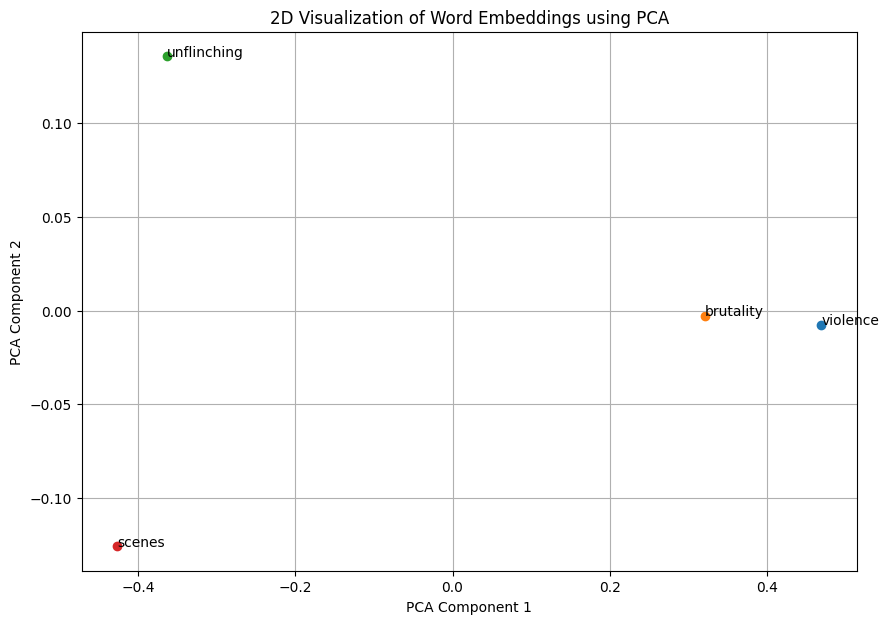

In [ ]:
# Plot the results
plt.figure(figsize=(10, 7))
# Iterate over the word vectors and their corresponding words
for i, (word, vector) in enumerate(zip(words_to_visualize, word_vectors)):
    plt.scatter(pca_result[i, 0], pca_result[i, 1])
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

plt.title("2D Visualization of Word Embeddings using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()